In [1]:
import os
import json
import numpy as np
from datetime import datetime
import csv

from collections import defaultdict, Counter
from tqdm import tqdm

start_date_str = "20230101000000"
cutoff_date_str = "20240301000000"
end_date_str = "20250407000000"

start_date = datetime.strptime(start_date_str, "%Y%m%d%H%M%S")
cutoff_date = datetime.strptime(cutoff_date_str, "%Y%m%d%H%M%S")
num_days_expected = (cutoff_date - start_date).days+1

bot2llm_date = {
    "Amazonbot": "2023-09-28",
    "FacebookBot": "2023-02-24",
    "Bytespider": "2023-08-18",
    "Yeti": "2023-08-24",
    "Baiduspider": "2023-08-31",
    "PetalBot": "2023-03-20",
    "CCBot": "2009-05-11",
    "Omgilibot": "2013-12-11",
    "BingBot": "2023-09-21",
}

historical_robots_file = f"../measurement_data/historical_tranco_robots_data_{start_date_str[:8]}_{end_date_str[:8]}.json"
with open(historical_robots_file, 'r') as f:
    all_snapshots_data = json.load(f)

csv_file = f'../measurement_data/tranco_top-1m_{end_date_str[:8]}.csv'
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    rows = list(reader)
    total_rows = len(rows)
url2tranco_rank = {row[1]: row[0] for row in rows}

with open(f"../measurement_data/url2botinfo_20240411.json", 'r') as f:
    url2botinfo = json.load(f)

In [2]:
filtered_snapshots_data = {}

for site, snapshots in all_snapshots_data.items():
    if site not in url2tranco_rank or int(url2tranco_rank[site]) > 10000:
        continue
    filtered_snapshots = [snapshot for snapshot in snapshots if snapshot['timestamp'] <= cutoff_date_str]
    coverage_percentage = round((len(snapshots) / num_days_expected) * 100)
    
    # filter by coverage percentage
    if filtered_snapshots and coverage_percentage >= 80:
        filtered_snapshots_data[site] = filtered_snapshots

print(f"Total number of snapshots: {len(all_snapshots_data)}, \n"
      f"Number of filtered snapshots (top 10k sites with >=80% coverage): {len(filtered_snapshots_data)}")
snapshots_data = {url: data for url, data in filtered_snapshots_data.items() if url in url2botinfo}

Total number of snapshots: 995, 
Number of filtered snapshots (top 10k sites with >=80% coverage): 429


In [3]:
def get_bot_list(robots_txt):
    bots = []
    for line in robots_txt.split('\n'):
        if line.strip().startswith('#'):
            continue
        parts = [part.strip() for part in line.split(':') if part.strip()]
        if len(parts) != 2:
            continue
        
        key, value = parts
        key = key.lower()
        value = value.split('#', 1)[0].strip() 
        
        if key == 'user-agent':
            bots.append(value)

    return bots

url2ts_bot_list = defaultdict(list)
for url, snapshot_data in filtered_snapshots_data.items():
    for snapshot in snapshot_data:
        url2ts_bot_list[url].append(
            (snapshot['timestamp'],
             get_bot_list(snapshot['html_content']))
             )

### Count domains with target bots listed in first snapshot, before, and after


In [4]:
from datetime import datetime
from tqdm import tqdm

# Reinitialize unique counts to include a category for the first snapshot
bot2count = {bot: {"before": set(), "after": set(), "first_snapshot": set()} for bot in bot2llm_date.keys()}

# Process each website once to determine its category (before, after, or first snapshot) for each bot
for url, snapshots_list in tqdm(snapshots_data.items()):
    clean_url = url[4:] if url.startswith("www.") else url
    for bot, date in bot2llm_date.items():
        bot_date = datetime.strptime(date, "%Y-%m-%d")
        
        # Initialize flags to avoid redundant checks
        added_before, added_after = False, False
        
        # Sort snapshots by timestamp to ensure the first snapshot is processed first
        snapshots_list_sorted = sorted(snapshots_list, key=lambda x: x["timestamp"])
        if bot in snapshots_list_sorted[0]['html_content']:
            bot2count[bot]["first_snapshot"].add(clean_url)

        for snapshot in snapshots_list_sorted:
            if not added_before or not added_after:
                timestamp = snapshot["timestamp"]
                html_content = snapshot["html_content"]
                snapshot_date = datetime.strptime(timestamp[:8], "%Y%m%d")
                if bot in html_content:
                    # Check for the first snapshot
                    # Then categorize based on the date relative to bot_date
                    if snapshot_date < bot_date and not added_before:
                        bot2count[bot]["before"].add(clean_url)
                        added_before = True
                    elif snapshot_date > bot_date and not added_after:
                        bot2count[bot]["after"].add(clean_url)
                        added_after = True

# Convert sets to counts, including the first snapshot
url_counts = {bot: {"before": len(urls["before"]), "after": len(urls["after"]), "first_snapshot": len(urls["first_snapshot"])} for bot, urls in bot2count.items()}

100%|██████████| 427/427 [00:05<00:00, 72.96it/s]


## Plot (Figure 4 in the paper)

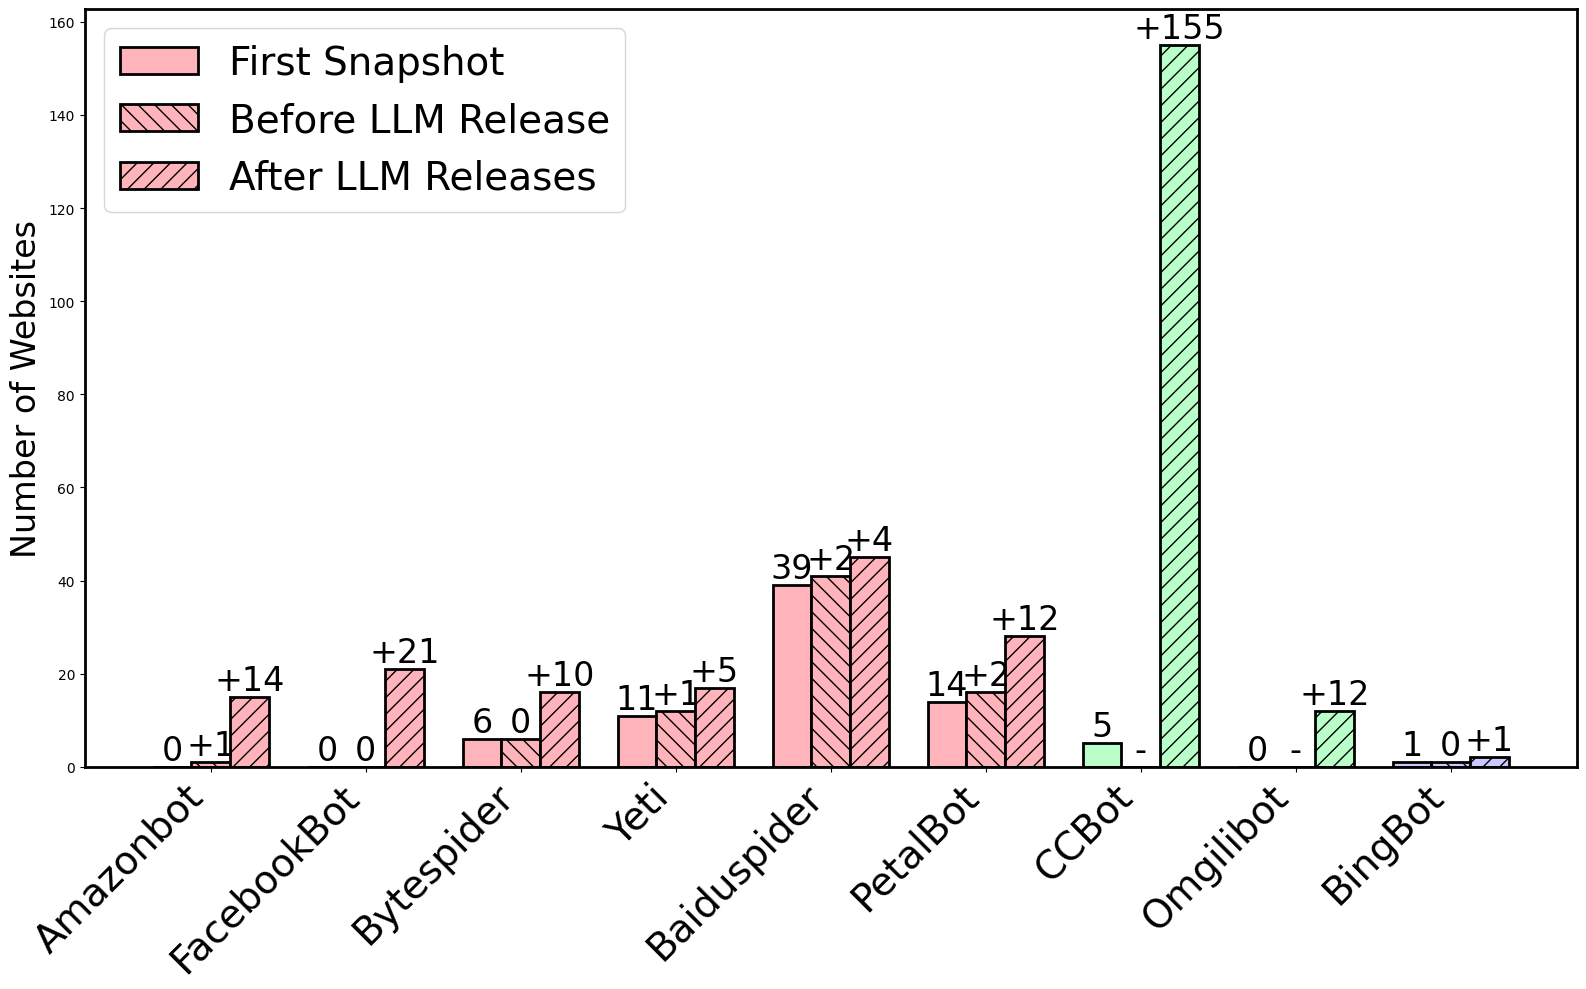

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming url_counts is already defined
bots = list(url_counts.keys())

# Define colors for each category
colors = {
    'LLM Bots': '#ffb3ba',  # Pastel red
    'Databroker Bots': '#baffc9',  # Pastel green 
    'RAG Bots': '#c9c9ff',  # Pastel purple
}

# Define a function to assign colors based on bot names
def get_color(bot_name):
    if bot_name in ['CCBot', 'Omgilibot']:
        return colors['Databroker Bots']
    elif bot_name == 'BingBot':
        return colors['RAG Bots']
    else:
        return colors['LLM Bots']

# Extract counts for each bot
before_counts = [url_counts[bot]['before'] for bot in bots]
first_day_counts = [url_counts[bot]['first_snapshot'] for bot in bots]
after_counts = [url_counts[bot]['after'] for bot in bots]

# Define the plot size
fig, ax = plt.subplots(figsize=(16, 10))

# Define bar width and x-axis indexes
bar_width = 0.25
x_indexes = np.arange(len(bots))

# Loop through each bot to plot the bars
for i, bot in enumerate(bots):
    # Get the color for the current bot
    color = get_color(bot)
    # print(bot, color)
    # First Snapshot - solid fill
    bar_first_day = ax.bar(x_indexes[i] - bar_width, first_day_counts[i], bar_width, 
                           color=color, edgecolor='black', linewidth=2)
    ax.annotate(first_day_counts[i], (bar_first_day[0].get_x() + bar_first_day[0].get_width() / 2, 
                bar_first_day[0].get_height()), ha='center', va='bottom', fontsize=24)

    # Before - apply dot pattern
    bar_before = ax.bar(x_indexes[i], before_counts[i], bar_width, 
                        color=color, edgecolor='black', linewidth=2, hatch='\\\\')
    
    if bot in ['CCBot', 'Omgilibot']:
        ax.annotate('-', (bar_before[0].get_x() + bar_before[0].get_width() / 2, 
                    bar_before[0].get_height()), ha='center', va='bottom', fontsize=24)
    else:
        diff_before = before_counts[i] - first_day_counts[i]
        ax.annotate(f'+{diff_before}' if diff_before > 0 else diff_before, 
                    (bar_before[0].get_x() + bar_before[0].get_width() / 2, 
                    bar_before[0].get_height()), ha='center', va='bottom', fontsize=24)

    # After - apply star pattern
    bar_after = ax.bar(x_indexes[i] + bar_width, after_counts[i], bar_width, 
                       color=color, edgecolor='black', linewidth=2, hatch='//')
    diff_after = after_counts[i] - before_counts[i]
    ax.annotate(f'+{diff_after}' if diff_after > 0 else diff_after, 
                (bar_after[0].get_x() + bar_after[0].get_width() / 2, 
                bar_after[0].get_height()), ha='center', va='bottom', fontsize=24)

# Set the plot's borders thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set labels and tick marks
ax.set_ylabel('Number of Websites', fontsize=24)
ax.set_xticks(x_indexes)
ax.set_xticklabels(bots, rotation=45, ha="right", fontsize=28)

# Add a legend to distinguish between the categories
ax.legend(['First Snapshot', 'Before LLM Release', 'After LLM Releases'], fontsize=28, loc='upper left')

# Optimize layout and show the plot
plt.tight_layout()
plt.savefig('plots/before_after_llm_release.pdf', dpi=300)
plt.show()

## Print domains that add bots after model release

In [6]:
new_urls = []
for bot, data in bot2count.items():
    print(bot)
    # print(data['before'] - data['after'])
    print(data['after'] - data['before'])
    if bot in ['Amazonbot', 'FacebookBot', 'Bytespider']:
        new_urls += (data['after'] - data['before'])

print(Counter(new_urls))

Amazonbot
{'stackoverflow.com', 'vogue.com', 'arstechnica.com', 'askubuntu.com', 'nj.com', 'superuser.com', 'pitchfork.com', 'gq.com', 'gravatar.com', 'newyorker.com', 'epicurious.com', 'wired.com', 'tumblr.com', 'nytimes.com'}
FacebookBot
{'change.org', 'rottentomatoes.com', 'lastampa.it', 'arstechnica.com', 'nj.com', 'pitchfork.com', 'repubblica.it', 'fivethirtyeight.com', 'jotform.com', 'tumblr.com', 'nytimes.com', 'patreon.com', 'twitter.com', 'vogue.com', 'gq.com', 'gravatar.com', 'theguardian.com', 'newyorker.com', 'epicurious.com', 'wired.com', 'reuters.com'}
Bytespider
{'spiegel.de', 'imageshack.com', 'notion.so', 'yomiuri.co.jp', 'fivethirtyeight.com', 'money.pl', 'imageshack.us', 'theguardian.com', 'nytimes.com', 'blesk.cz'}
Yeti
{'okx.com', 'spiegel.de', 'france24.com', 'rfi.fr', 'blesk.cz'}
Baiduspider
{'news18.com', 'moneycontrol.com', 'seek.com.au', 'spiegel.de'}
PetalBot
{'freelancer.com', 'cc.com', 'mtv.com', 'playstation.com', 'criteo.com', 'tiktok.com', 'ghanaweb.com'